- Generate a grid of FSPS spectra (in age and metallicity)
- perform PCA on this grid
- Perform gaussian processes regression on the coefficients 

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from astropy.cosmology import Planck15 as cosmo

import fsps

from sklearn.decomposition import PCA

In [2]:
sp = fsps.StellarPopulation(zcontinuous=1, sfh=0, logzsol=0.0)

wl = np.array(sp.get_spectrum(tage=13, peraa=True)).T[:,0]

!! high metallicites blow up the SED, not sure why !!

In [33]:
Nage = 20
NZ = 20

ages = np.linspace(2e-1, cosmo.age(0).value, num=Nage)
metallicities = np.log(np.linspace(5e-3, 1.4e-2, num=NZ) / 0.0134)  # log(Z / Zsol)

In [34]:
spec = np.zeros((len(ages), len(metallicities), 5994))

for i, a in enumerate(ages):
    for j, Z in enumerate(metallicities):

        sp.params['logzsol'] = Z

        spec[i,j] = np.log10(sp.get_spectrum(tage=a, peraa=True)[1])


In [35]:
# plt.semilogx(wl, spec[0,0])

In [36]:
# for s in spec.reshape((len(ages)*len(metallicities), 5994)):
#     plt.semilogx(wl, s, alpha=0.1)


## PCA

In [37]:
shape = len(ages) * len(metallicities)

In [38]:
comps = 40
spectra_pca = PCA(n_components=comps)
spectra_pca.fit(spec.reshape((shape, 5994)))

PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

/home/chris/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


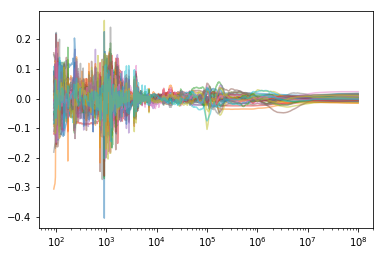

In [39]:
# plt.semilogx(wl, spectra_pca.mean_, label='mean', color='black')

for component in spectra_pca.components_:
    plt.semilogx(wl, component, alpha=0.5)

plt.legend()

In [40]:
coeffs = np.array(spectra_pca.transform(spec.reshape((shape, 5994))))
coeffs = coeffs.reshape((len(ages),len(metallicities),comps))
coeffs.shape

(20, 20, 40)

6.64097631458 -0.895302786982


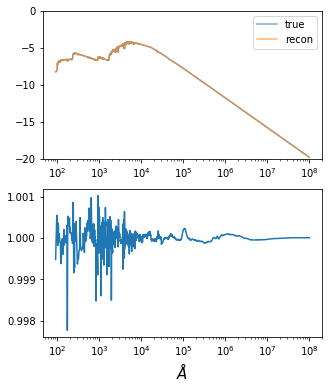

In [41]:
# reconstruct SFH
i = 9
j = 1
k = 1

print(ages[i], metallicities[j])

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,6))

ax1.semilogx(wl, spec[i,j], label='true', alpha=0.6)
ax1.semilogx(wl, spectra_pca.mean_ + np.dot(coeffs[i,j], spectra_pca.components_), label='recon', alpha=0.6)

ax1.legend()

ax1.set_ylim(-20, 0)

ax2.semilogx(wl, spec[i,j] / (spectra_pca.mean_ + np.dot(coeffs[i,j], spectra_pca.components_)))

ax2.set_xlabel('$\AA$', size=15)

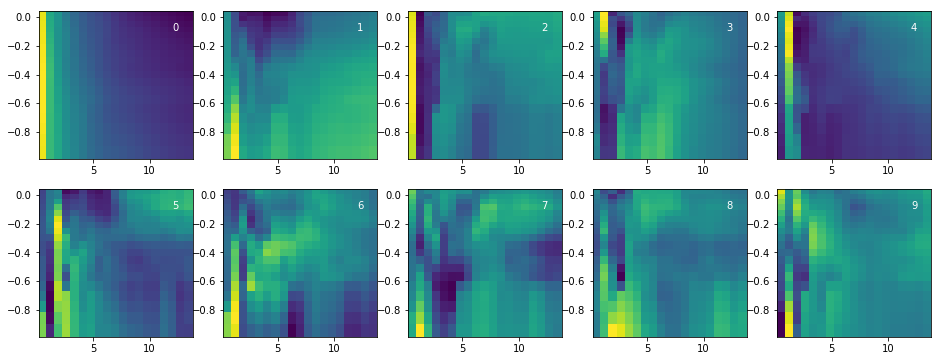

In [42]:
fig, axes = plt.subplots(2,5, figsize=(16,6))

axes = axes.flatten()

for i, ax in enumerate(axes):
    img = ax.pcolormesh(ages, metallicities, coeffs[:,:,i].T)
    ax.text(12, -0.1, i, color='white')
    

## Regression

In [43]:
from scipy.interpolate import interp2d, Rbf, RegularGridInterpolator

In [44]:
f = [None] * comps

xx, yy = np.meshgrid(ages, metallicities)

for i in range(comps):
#     f[i] = interp2d(ages, metallicities, coeffs[:,:,i].T, kind='cubic')
    f[i] = RegularGridInterpolator((ages, metallicities), coeffs[:,:,i])
#     f[i] = Rbf(xx, yy, zz, coeffs[:,:,:,i].T)


In [45]:
# i = 5
# j = 9

# a = ages[i]
# Z = metallicities[j]

# print(coeffs[i,j])

a = 12.1
Z = -0.07

print(a,Z)

interp_coeffs = np.array([f[c]((a, Z)) for c in np.arange(comps)]).flatten()
print(interp_coeffs)

12.1 -0.07
[ -3.09882181e+01  -1.57664538e+00   3.47174088e+00  -1.89171562e+00
   2.21223982e+00   1.87181817e+00   2.81755601e-02   7.63052297e-01
  -4.83689560e-02   1.68704762e-02   5.15802933e-01  -2.19393131e-01
   5.18409983e-04  -2.04243387e-01  -6.46985029e-02  -2.13245342e-02
   2.77150428e-02   8.45111508e-03  -1.69165417e-02   3.28260959e-02
  -1.05237893e-01  -2.75470994e-02  -5.89000268e-02  -9.96101955e-02
   8.36425366e-02  -7.87284148e-02  -1.43161548e-02   1.87972488e-02
  -6.26900037e-02  -1.77937427e-02   1.72913445e-02   2.68692386e-02
   2.32548558e-02  -5.45337377e-02  -4.29799367e-02  -2.19087182e-02
   6.41757849e-03  -4.47432811e-03  -2.06356960e-02   1.86462502e-02]


In [46]:
sp.params['logzsol'] = Z

test_spec = np.log10(sp.get_spectrum(tage=a, peraa=True)).T[:,1]

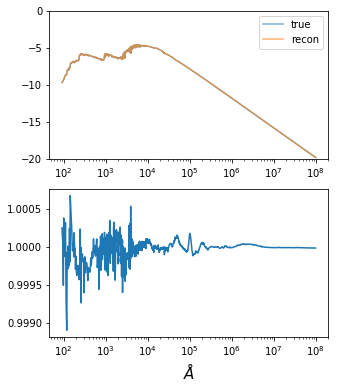

In [47]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,6))

ax1.semilogx(wl, test_spec, label='true', alpha=0.6)
ax1.semilogx(wl, spectra_pca.mean_ + np.dot(interp_coeffs, spectra_pca.components_), label='recon', alpha=0.6)

ax1.legend()

ax1.set_ylim(-20, 0)

ax2.semilogx(wl, test_spec / (spectra_pca.mean_ + np.dot(interp_coeffs, spectra_pca.components_)))

ax2.set_xlabel('$\AA$', size=15)

Compare to interpolation in spectra-space

In [48]:
from sph2sed.weights import calculate_weights

In [49]:
w = calculate_weights(ages.astype(np.float64), metallicities.astype(np.float64),
                  np.array([[a],[Z],[1]], dtype=np.float32).T)

interp_sed = np.nansum(spec * w, (0,1))

/home/chris/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


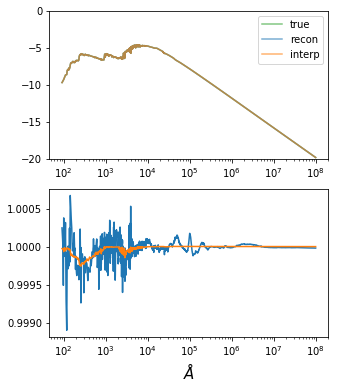

In [50]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,6))

ax1.semilogx(wl, test_spec, label='true', alpha=0.6, c='C2')
ax1.semilogx(wl, spectra_pca.mean_ + np.dot(interp_coeffs, spectra_pca.components_), label='recon', alpha=0.6, c='C0')
ax1.semilogx(wl, interp_sed, label='interp', alpha=0.6, c='C1')

ax1.legend()

ax1.set_ylim(-20, 0)

ax2.semilogx(wl, test_spec / (spectra_pca.mean_ + np.dot(interp_coeffs, spectra_pca.components_)), c='C0')
ax2.semilogx(wl, test_spec / interp_sed, c='C1')

ax2.set_xlabel('$\AA$', size=15)

ax2.legend()